In [84]:

import pandas as pd
import matplotlib.pyplot as plt

path = "../data/processed/amazon_mi_clean.csv"
main = pd.read_csv(path)

In [114]:
#import re

#term = "would recommend anyone"
#mask = main['review'].str.contains(re.escape(term), case=False, na=False)
#rows = main.loc[mask]                 # all rows where the term appears anywhere
#print(rows)
#main["text_clean"][2940]
#main["review"][2940]
# 102
#30
#1500


**What is the rating distribution?**

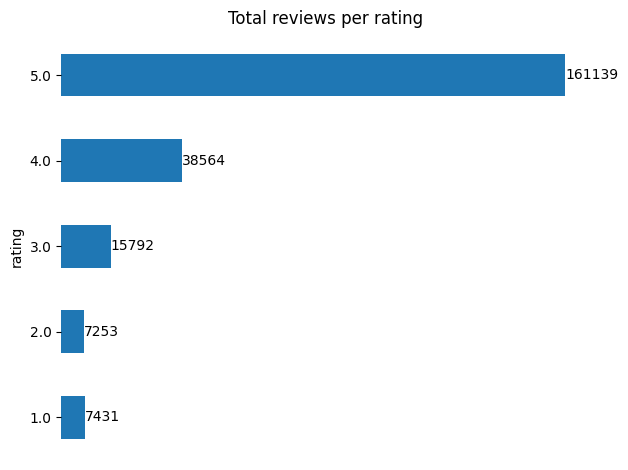

In [115]:
#Rating distribution
ax = main['rating'].value_counts().sort_index().plot(kind='barh')
# Remove x-ahi, figsize=(7,4)ylabel('Rating')
plt.xticks([])
plt.title('Total reviews per rating')
for i, v in enumerate(main['rating'].value_counts().sort_index()):
    ax.text(v + 3, i, str(v), color='black', va='center')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

1. Rating is more skewed towards -ve reviews, left skewed graph
2. positive reviews are 13x than the -ve review, and neutral reviews are similar to -ve reviews.

**What is the timeline distribution?**

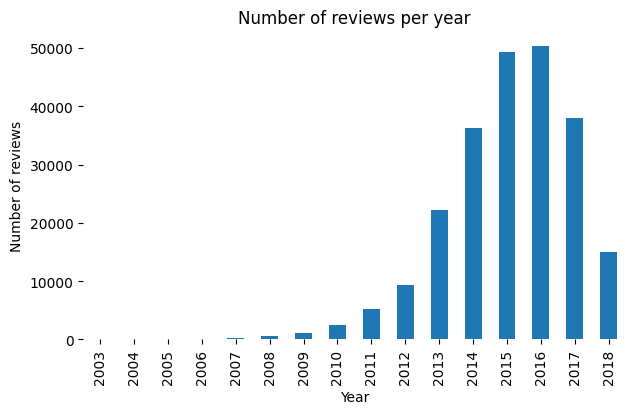

In [94]:
main['reviewTime'] = pd.to_datetime(main['reviewTime'])
main['reviewYear'] = main['reviewTime'].dt.year
main['reviewMonth'] = main['reviewTime'].dt.month
main['reviewDay'] = main['reviewTime'].dt.day

#main['reviewYear'].value_counts()

ax = main['reviewYear'].value_counts().sort_index().plot(kind='bar', figsize=(7,4))
plt.title('Number of reviews per year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()


1. 85% of the total reviews are in between 2013 to 2017 period. where 2016-22% and 2015-21% of total reviews respectively 
2. 2018 period contributes 6.5% of total reviews
3. In 2yrs the no of reviews has fallen by 70%
4. So people are taking decision on the reviews of which 60% are 2-4 yrs old  

**As timeline progressed how did the rating distribution progress?**

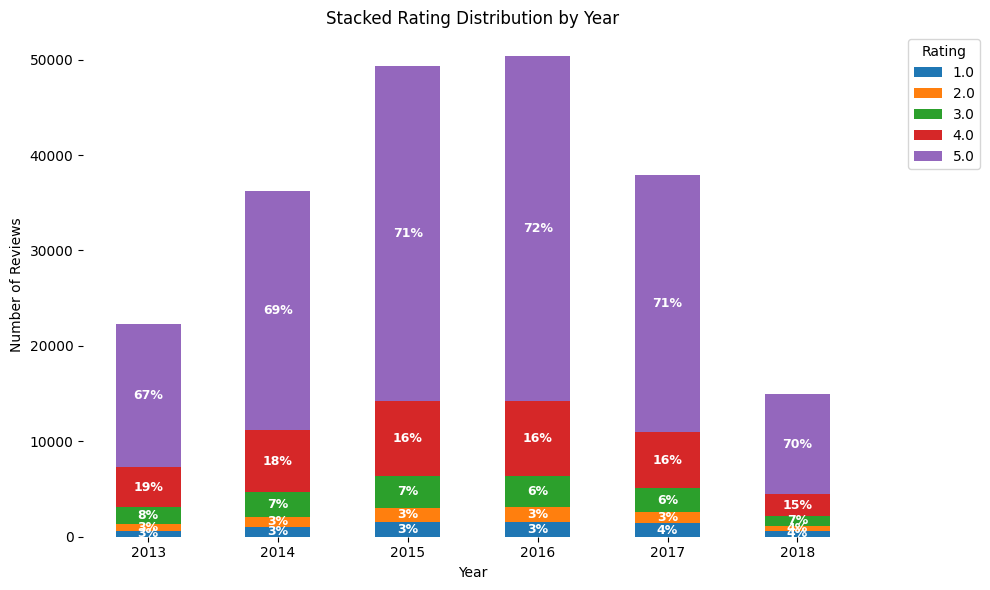

In [95]:
# Stacked bar plot: Rating distribution by year with % labels inside segments
df_year_rating = main[['reviewYear', 'rating']].dropna()
df_year_rating = df_year_rating[df_year_rating['reviewYear'] > 2012]

ct = pd.crosstab(df_year_rating['reviewYear'], df_year_rating['rating'])
ct = ct.sort_index(axis=1).sort_index(axis=0)

ax = ct.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='none')
plt.title('Stacked Rating Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

# Clean spines
for spine in ax.spines.values():
    spine.set_visible(False)

# --- Add % labels inside each stacked segment ---
import numpy as np

totals = ct.sum(axis=1).values  # total reviews per year (one per bar)


for container in ax.containers:  # one container per rating (stack level)
    # heights of this rating for each year (i.e., segment heights)
    heights = np.array([patch.get_height() for patch in container.patches])

    # percentages for this rating within each year's total
    perc = np.divide(heights, totals, out=np.zeros_like(heights, dtype=float), where=totals > 0) * 100

    # Optional: skip very small segments to avoid clutter
    labels = [f'{p:.0f}%' for h, p in zip(heights, perc)]

    ax.bar_label(
        container,
        labels=labels,
        label_type='center',   # center within each segment
        fontsize=9,
        color='white',
        fontweight='bold',
        padding=0
    )

# Ensure x-ticks show years cleanly
ax.set_xticklabels(ct.index.astype(str), rotation=0)

plt.tight_layout()
plt.savefig('../reports/figures/eda_rating_year_stacked.png', dpi=150)
plt.show()

1. The positive reviews reduced by 3%(abs) from 88% to 85% in last 3yrs, negative reviews rose by 2% from 6% to 8%
2. Ove the 5 yr period the positive revivews increased and reduced back to same level, where as -ve reviews stayed stable till 2015 but started increasing from 2015.
3. So, from the period 2013 to 2016 the increase in +ve reviews, but stable -ve reviews show small fixes in the issues caused neutral reviews.
4. The slow reduction of +ve reivews from 2016 indicates there were no action/ less action taken to address -ve issues. { Irrespective of sales this looks valid }
5. The fall in the total ratings show that people are not bothered by rating, may be since the total availale ratings are too many. or  majority of people are feeling to rate only if they have issues.  { This assumption works only if sales are similar to last years}

**what are top vocabs used in +ve, -ve and neutral?**

In [118]:
# Top bigrams for positive, negative, and neutral reviews
from sklearn.feature_extraction.text import CountVectorizer
def get_top_bigrams(texts, n=20):
    vect = CountVectorizer(ngram_range=(2,2), min_df=5, max_df=0.9)
    X = vect.fit_transform(texts.dropna())
    counts = X.sum(axis=0).A1
    vocab = vect.get_feature_names_out()
    top = pd.DataFrame({'bigram': vocab, 'count': counts}).sort_values('count', ascending=False).head(n)
    return top

# Define sentiment mapping if not already present
def get_sentiment(rating):
    if rating >= 4: return 'positive'
    elif rating == 3: return 'neutral'
    else: return 'negative'
if 'sentiment' not in main.columns:
    main['sentiment'] = main['rating'].apply(get_sentiment)

top_pos = get_top_bigrams(main[main['sentiment']=='positive']['text_clean'])
top_neg = get_top_bigrams(main[main['sentiment']=='negative']['text_clean'])
top_neu = get_top_bigrams(main[main['sentiment']=='neutral']['text_clean'])

print('Top Positive Bigrams:')
display(top_pos)
print('Top Negative Bigrams:')
display(top_neg)
print('Top Neutral Bigrams:')
display(top_neu)

Top Positive Bigrams:


,bigram,count
158264,works great,7427
158420,works well,4884
155581,well made,4505
53846,great price,4111
51943,good quality,3998
53857,great product,3796
35431,easy use,3473
126305,sound great,3255
59729,highly recommend,3086
127431,sounds great,2933


Top Negative Bigrams:


,bigram,count
5381,much better,342
10190,waste money,339
2987,get pay,334
10784,would recommend,276
7809,sent back,270
6658,power supply,260
8295,sound quality,212
7647,save money,209
8646,stopped working,194
10558,work well,186


Top Neutral Bigrams:


,bigram,count
6010,much better,348
11825,works well,327
11754,work well,321
11792,works fine,282
7547,pretty good,271
9250,sound quality,265
11543,well made,254
3202,get pay,242
9193,sound good,227
11957,would recommend,211


In [119]:
# Top trigrams for positive, negative, and neutral reviews
from sklearn.feature_extraction.text import CountVectorizer
def get_top_bigrams(texts, n=20):
    vect = CountVectorizer(ngram_range=(3,3), min_df=5, max_df=0.9)
    X = vect.fit_transform(texts.dropna())
    counts = X.sum(axis=0).A1
    vocab = vect.get_feature_names_out()
    top = pd.DataFrame({'bigram': vocab, 'count': counts}).sort_values('count', ascending=False).head(n)
    return top

# Define sentiment mapping if not already present
def get_sentiment(rating):
    if rating >= 4: return 'positive'
    elif rating == 3: return 'neutral'
    else: return 'negative'
if 'sentiment' not in main.columns:
    main['sentiment'] = main['rating'].apply(get_sentiment)

top_pos = get_top_bigrams(main[main['sentiment']=='positive']['text_clean'])
top_neg = get_top_bigrams(main[main['sentiment']=='negative']['text_clean'])
top_neu = get_top_bigrams(main[main['sentiment']=='neutral']['text_clean'])

print('Top Positive Trigrams:')
display(top_pos)
print('Top Negative Trigrams:')
display(top_neg)
print('Top Neutral Trigrams:')
display(top_neu)

Top Positive Bigrams:


,bigram,count
15971,last long time,971
37970,would highly recommend,491
37740,worth every penny,484
10077,gets job done,447
3556,built like tank,428
12340,great product great,428
38107,would recommend anyone,421
36460,well worth money,390
25061,product great price,363
37888,would definitely recommend,357


Top Negative Bigrams:


,bigram,count
1257,waste time money,55
946,save money buy,49
898,really wanted like,47
430,got bad one,45
639,maybe got bad,33
586,local music store,28
1065,spend extra money,26
1325,would recommend anyone,26
947,save money get,25
369,gave two stars,25


Top Neutral Bigrams:


,bigram,count
259,gets job done,84
247,get job done,71
369,last long time,44
431,local music store,29
1015,works well enough,29
160,epiphone les paul,28
234,gave three stars,27
95,buy another one,25
779,sound pretty good,24
1028,would give stars,23


1. Bigrams ands trigrams show the clear difference in the top repeated words in the reivew.
2. Higher count of bigrams and tri grams related to quality, price and performance
3. In negative reviews higher count for suggesting to buy elsewhere suggesting quailty or performance issues. So, people expect performance to the price the product is sold.

**for positive reviewes what is leading to positive reviwes? experience(sounding, ease), product quality, price etc?**   

**for negative reviewes what is leading to negative reviwes? experience(sounding, ease), product quality, price etc?**   